In [1]:
import librosa
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import librosa
import librosa.display
import json

In [188]:
SingerN = "JIJ"

SongN = "Wish"


In [189]:
audio_file_path = "vocal_extract/" + SingerN + "_" + SongN + ".wav"

In [190]:
converted_audio_file = audio_file_path
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')
duration = len(audio_samples)/sample_rate

In [191]:
y, sr = librosa.load(converted_audio_file, sr=sample_rate)

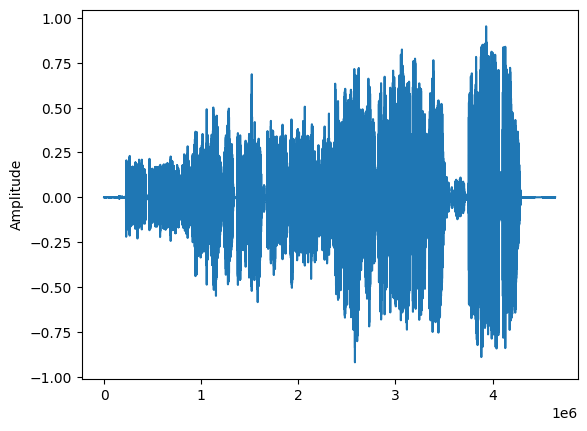

In [192]:
# 웨이브폼을 시각화합니다.
plt.plot(y)
plt.ylabel("Amplitude")
plt.show()

In [193]:
def GetMFCC(music_data):
    # MFCC 계산
    n_fft = 2048
    hop_length = 512
    mfcc = librosa.feature.mfcc(y=music_data, sr=sr, n_mfcc=20, n_fft=n_fft, hop_length=hop_length)
    return mfcc

def output2hz(pitch_output):
    # Constants taken from https://tfhub.dev/google/spice/2
    PT_OFFSET = 25.58
    PT_SLOPE = 63.07
    FMIN = 10.0
    BINS_PER_OCTAVE = 12.0
    #뭘까
    cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET
    return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)

def value_to_hertz(values):    
    return [0 if x==0 else output2hz(x) for x in values]

def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x==0 else x for x in values]

# 해당 부분 음정이 끊어지는 부분 알기 위해서 
def m_s_to_seconds(time_str):
    # ":"를 기준으로 분과 초를 분리하여 리스트로 저장
    minutes, seconds = time_str.split(':')
    # 분과 초를 정수형으로 변환하여 합산 후 반환
    total_seconds = int(minutes) * 60 + int(seconds)
    return total_seconds


def Cutting_time(outputs_datetime_skip, outputs_pitch_skip):
    befor = 0
    cut = 0

    time_set = []
    group =[]

    for i in range(len(outputs_datetime_skip)):
        time_obj = outputs_datetime_skip[i].strftime("%M:%S")
        time_obj_int = m_s_to_seconds(time_obj)
        
        befor=time_obj_int

        if(outputs_pitch_skip[i] >= 0):

            if(cut == time_obj_int-1):
                cut = time_obj_int
                group.append(time_obj)

            if(cut < time_obj_int-1):
                if(len(group) != 0):
                    time_set.append(group)
                group = []
                group.append(time_obj)
                print("here")
                cut = time_obj_int

            print(time_obj, outputs_pitch_skip[i])

    time_set.append(group)

    return time_set

def Find_Breakpoint(time_set):
    breakpoint_list =[]

    for list in time_set:   
        if(len(list) >= 5):
            print(list)
            breakpoint_list.append(list)

    return breakpoint_list

def extract_MFCC_features(converted_audio_file, rate, breakpoint_list):
    n_fft = 2048
    hop_length = 512
    num_mfcc = 20  # MFCC 특징의 개수 설정

    mfccfeature_timestemp = []

    mfcc_features =[]
    
    for breakpoints in breakpoint_list:
        start_time = m_s_to_seconds(breakpoints[0])
        end_time = m_s_to_seconds(breakpoints[-1])

        #일단 10초 단위로 짤라봄 
        while (start_time + 10) <= end_time or (start_time+10) == end_time+1:
            print(start_time, start_time+10)

            mfccfeature_timestemp.append([start_time, start_time+10])
            # 오디오 데이터를 로드하고 자른 후 MFCC 추출
            y, sr = librosa.load(converted_audio_file, sr=rate, offset=start_time, duration=(start_time+10)-start_time)

            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=num_mfcc)
            
            # MFCC 데이터를 평균화하여 특징 벡터로 변환
            mfcc_mean = np.mean(mfcc, axis=1)
            
            # 특징 벡터를 리스트에 추가
            mfcc_features.append(mfcc_mean)

            #start_time 증가
            start_time += 10
    
    return np.array(mfcc_features), mfccfeature_timestemp


def Mk_MFCC_JSON(mfccfeature_timestemp, mfccfeature):
    MFCC_json =[]

    for time, mfccf in zip(mfccfeature_timestemp, mfccfeature):

        print(mfccf)

        data ={
            "time":time,
            "feature":mfccf.tolist()
        }

        MFCC_json.append(data)
    
    return MFCC_json

In [194]:
CSV_file_path = "CSV/TTP_"+SingerN+"_"+SongN+".csv"


df = pd.read_csv(CSV_file_path)

pitch_time = list(df['time'])
pitch_pitch = list(df['pitch'])

In [195]:
outputs_index_skip = []
outputs_pitch_func = zero_to_nan(value_to_hertz(pitch_pitch))
outputs_pitch_skip = []
outputs_datetime_skip = []

for i in range(int(len(outputs_pitch_func))):
    outputs_index_skip.append(i)
    outputs_pitch_skip.append(np.nanmean(outputs_pitch_func[i]))
    outputs_datetime_skip.append(datetime.datetime.fromtimestamp(i * 32 / 1000))

C:\Users\hyun9\AppData\Local\Temp\ipykernel_14712\3864108359.py:8: RuntimeWarning: Mean of empty slice
  outputs_pitch_skip.append(np.nanmean(outputs_pitch_func[i]))


In [196]:
time_set = Cutting_time(outputs_datetime_skip, outputs_pitch_skip)

here
00:07 332.61228562215615
here
00:14 112.51210931261693
00:14 114.41445028052824
00:14 120.47373858468525
00:14 131.5095030379891
00:14 145.173682274145
00:14 146.4796946848997
00:14 147.02639560781301
00:14 146.9242045685819
00:15 164.3639643816805
00:15 164.28476819747277
00:15 165.23531399443732
00:15 162.1516277079602
00:15 161.4047315529255
00:15 163.60895614816047
00:15 165.39440981353704
00:15 161.73399254841416
00:15 161.27708461585127
00:15 159.7251634251449
00:15 161.1408432017841
00:15 164.38545152274
00:15 163.9133470542438
00:16 196.46450167825347
00:16 195.12357015612446
00:16 194.4391867103082
00:16 194.12360712633532
00:16 195.42380059032706
00:16 197.16466183779175
00:17 196.66884751240514
00:17 195.49145375004247
00:17 191.73875017112772
00:17 194.16584873720302
00:17 172.53539186900966
00:17 173.6001399479461
00:17 174.3773223407895
00:17 174.6215326577645
00:17 174.54345808150322
00:17 174.65808939567546
00:17 174.52174215664934
00:17 174.6521351314263
00:17 175

In [197]:
breakpoint_list = Find_Breakpoint(time_set)

['00:14', '00:15', '00:16', '00:17', '00:18', '00:19', '00:20', '00:21', '00:22', '00:23', '00:24', '00:25', '00:26', '00:27']
['00:29', '00:30', '00:31', '00:32', '00:33', '00:34', '00:35', '00:36', '00:37', '00:38', '00:39', '00:40', '00:41', '00:42', '00:43', '00:44', '00:45', '00:46', '00:47', '00:48', '00:49', '00:50', '00:51', '00:52', '00:53', '00:54', '00:55', '00:56', '00:57', '00:58']
['01:00', '01:01', '01:02', '01:03', '01:04', '01:05', '01:06', '01:07', '01:08', '01:09']
['01:11', '01:12', '01:13', '01:14', '01:15', '01:16']
['01:18', '01:19', '01:20', '01:21', '01:22', '01:23']
['01:25', '01:26', '01:27', '01:28', '01:29', '01:30', '01:31', '01:32', '01:33', '01:34', '01:35', '01:36', '01:37', '01:38']
['01:42', '01:43', '01:44', '01:45', '01:46', '01:47', '01:48', '01:49', '01:50', '01:51', '01:52', '01:53']
['02:00', '02:01', '02:02', '02:03', '02:04', '02:05', '02:06', '02:07', '02:08', '02:09', '02:10', '02:11', '02:12', '02:13', '02:14', '02:15', '02:16', '02:17', '0

In [198]:
mfccfeature, mfccfeature_timestemp= extract_MFCC_features(converted_audio_file=converted_audio_file, rate=sample_rate, breakpoint_list=breakpoint_list)

14 24
29 39
39 49
49 59
60 70
85 95
102 112
120 130
130 140
140 150
174 184
234 244


In [199]:
MFCC_json = Mk_MFCC_JSON(mfccfeature_timestemp, mfccfeature)

[-305.41382     36.40631     -1.1566122   10.910223    10.699371
   -5.768677     1.3052452   -2.367993     2.827436     3.4207704
  -13.550934    -8.869114     2.574837    -5.4812217   -7.346399
  -20.48101     -3.258082   -15.762904   -15.303983   -13.842965 ]
[-327.43192     39.77243      1.4509412    5.5828853   15.625259
   -1.7256905    2.7512617   -5.438843     9.472541     9.312676
  -12.565879   -12.198833    -2.556169    -2.8551435   -7.127423
  -18.067854    -7.935398   -14.612882   -13.731653   -14.080215 ]
[-305.6009      40.05786      3.1970563   -1.4490798    6.130295
   -2.8768258    9.666868    -7.738179     3.0238643    5.059415
  -11.353929    -9.838981    -4.699658    -9.904612    -7.4564595
  -17.240805    -7.0133467  -12.107303   -14.673274   -14.443342 ]
[-303.5357       33.418842     14.220547     11.823737     10.3620405
  -10.295225      3.0086226    -7.473417     -1.908028     -0.38840654
  -13.065569     -6.573372     -5.230963     -7.8387485    -9.543585
  

In [200]:
#이름 규칙 
# 가수명_노래명_MFCC_Feature.json

JSON_File_Name = "JSON/"+SingerN + "_" + SongN + "_MFCC_feature.json"

with open(JSON_File_Name, "w") as json_file:
    json.dump(MFCC_json, json_file, indent=4)